In [1]:
# Importing libraries
import os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
import librosa as lb
import librosa.display
import IPython.display as ipd
from IPython.core.display import display
from sklearn.model_selection import train_test_split
import time
import pyaudio
import joblib
import wave
import sounddevice as sd
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")

C:\Users\Majid\AppData\Local\Temp\ipykernel_24952\430526234.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


### Getting the data

In [2]:
# Getting TESS data:
paths, labels, duration = [], [], []

for dirname, _, filenames in os.walk('C:\\Users\\Majid\\Programming Files\\FYP\Datasets\\TESS Toronto emotional speech set data'):
    for filename in filenames:
        
        paths.append(os.path.join(dirname, filename))
        
        duration.append(round(librosa.get_duration(filename=paths[-1]), 3))
        
        label = filename[::-1].split('_')[0][::-1]
        labels.append(label[:-4].lower())

df_tess = pd.DataFrame({'path':paths,'duration': duration, 'dataset': 'TESS', 'emotion':labels})

df_tess['emotion'] = df_tess['emotion'].replace(['ps'], 'surprise')
                  
df_tess.sample(5)

,path,duration,dataset,emotion
4540,C:\Users\Majid\Programming Files\FYP\Datasets\...,2.671,TESS,disgust
412,C:\Users\Majid\Programming Files\FYP\Datasets\...,1.658,TESS,fear
4403,C:\Users\Majid\Programming Files\FYP\Datasets\...,2.461,TESS,disgust
4300,C:\Users\Majid\Programming Files\FYP\Datasets\...,1.847,TESS,angry
5468,C:\Users\Majid\Programming Files\FYP\Datasets\...,2.236,TESS,sad


In [3]:
# Getting RAVDESS data
paths, labels, duration = [], [], []

for dirname, _, filenames in os.walk('C:\\Users\\Majid\\Programming Files\\FYP\\Datasets\\RAVDESS'):
    for filename in filenames:
        
        paths.append(os.path.join(dirname, filename))
        
        duration.append(round(librosa.get_duration(filename=paths[-1]), 3)) 
        
        label = filename[::-1].split('_')[0][::-1]
        
        if label[6:8] == '01':
            labels.append('neutral')
        elif label[6:8] == '02':
            labels.append('calm')
        elif label[6:8] == '03':
            labels.append('happy')
        elif label[6:8] == '04':
            labels.append('sad')
        elif label[6:8] == '05':
            labels.append('angry')
        elif label[6:8] == '06':
            labels.append('fear')
        elif label[6:8] == '07':
            labels.append('disgust')
        elif label[6:8] == '08':
            labels.append('surprise')       

df_ravdess = pd.DataFrame({'path':paths,'duration': duration, 'dataset': 'RAVDESS', 'emotion':labels})

df_ravdess.sample(5)

,path,duration,dataset,emotion
1332,C:\Users\Majid\Programming Files\FYP\Datasets\...,3.337,RAVDESS,happy
2420,C:\Users\Majid\Programming Files\FYP\Datasets\...,3.670,RAVDESS,sad
1133,C:\Users\Majid\Programming Files\FYP\Datasets\...,3.537,RAVDESS,surprise
1144,C:\Users\Majid\Programming Files\FYP\Datasets\...,3.637,RAVDESS,calm
2809,C:\Users\Majid\Programming Files\FYP\Datasets\...,3.871,RAVDESS,disgust


In [4]:
# Getting SAVEE data
paths, labels, duration = [], [], []

for dirname, _, filenames in os.walk('C:\\Users\\Majid\\Programming Files\\FYP\\Datasets\\SAVEE\\AudioData'):
    for filename in filenames:
        
        paths.append(os.path.join(dirname, filename))
        
        label = filename[::-1].split('_')[0][::-1]
        
        if label[:1] == 'a':
            labels.append('angry')
        elif label[:1] == 'd':
            labels.append('disgust')
        elif label[:1] == 'f':
            labels.append('fear')
        elif label[:1] == 'h':
            labels.append('happy')
        elif label[:1] == 'n':
            labels.append('neutral')
        elif label[:1] == 's':
            if label[:2] == 'sa':
                labels.append('sad')
            else:
                labels.append('surprise')

paths = paths[1:] # to filter out 'info.txt' file

for file in paths:
    duration.append(round(librosa.get_duration(filename=file), 3)) 

df_savee = pd.DataFrame({'path':paths, 'duration': duration, 'dataset': 'SAVEE', 'emotion':labels})
                  
df_savee.sample(5)

,path,duration,dataset,emotion
237,C:\Users\Majid\Programming Files\FYP\Datasets\...,4.925,SAVEE,surprise
114,C:\Users\Majid\Programming Files\FYP\Datasets\...,4.057,SAVEE,surprise
163,C:\Users\Majid\Programming Files\FYP\Datasets\...,4.843,SAVEE,fear
160,C:\Users\Majid\Programming Files\FYP\Datasets\...,4.523,SAVEE,fear
176,C:\Users\Majid\Programming Files\FYP\Datasets\...,5.617,SAVEE,happy


In [5]:
# Let's merge the datesets together, now that they have been formatted the same way:

df = pd.concat([df_tess, df_ravdess, df_savee])

# Dropping 'calm' as out the scope (also not many samples)
df = df[df['emotion'].str.contains('disgust|calm') == False].reset_index(drop=True)

print('The dataset has {} audio files. Below printed 5 random entries:'.format(df.shape[0]))

df.sample(5)

The dataset has 7332 audio files. Below printed 5 random entries:


,path,duration,dataset,emotion
3126,C:\Users\Majid\Programming Files\FYP\Datasets\...,1.879,TESS,neutral
925,C:\Users\Majid\Programming Files\FYP\Datasets\...,1.942,TESS,surprise
1418,C:\Users\Majid\Programming Files\FYP\Datasets\...,1.580,TESS,fear
4853,C:\Users\Majid\Programming Files\FYP\Datasets\...,3.670,RAVDESS,happy
5083,C:\Users\Majid\Programming Files\FYP\Datasets\...,3.837,RAVDESS,sad


### Exploratory Data Analysis (EDA)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7332 entries, 0 to 7331
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   path      7332 non-null   object 
 1   duration  7332 non-null   float64
 2   dataset   7332 non-null   object 
 3   emotion   7332 non-null   object 
dtypes: float64(1), object(3)
memory usage: 229.2+ KB


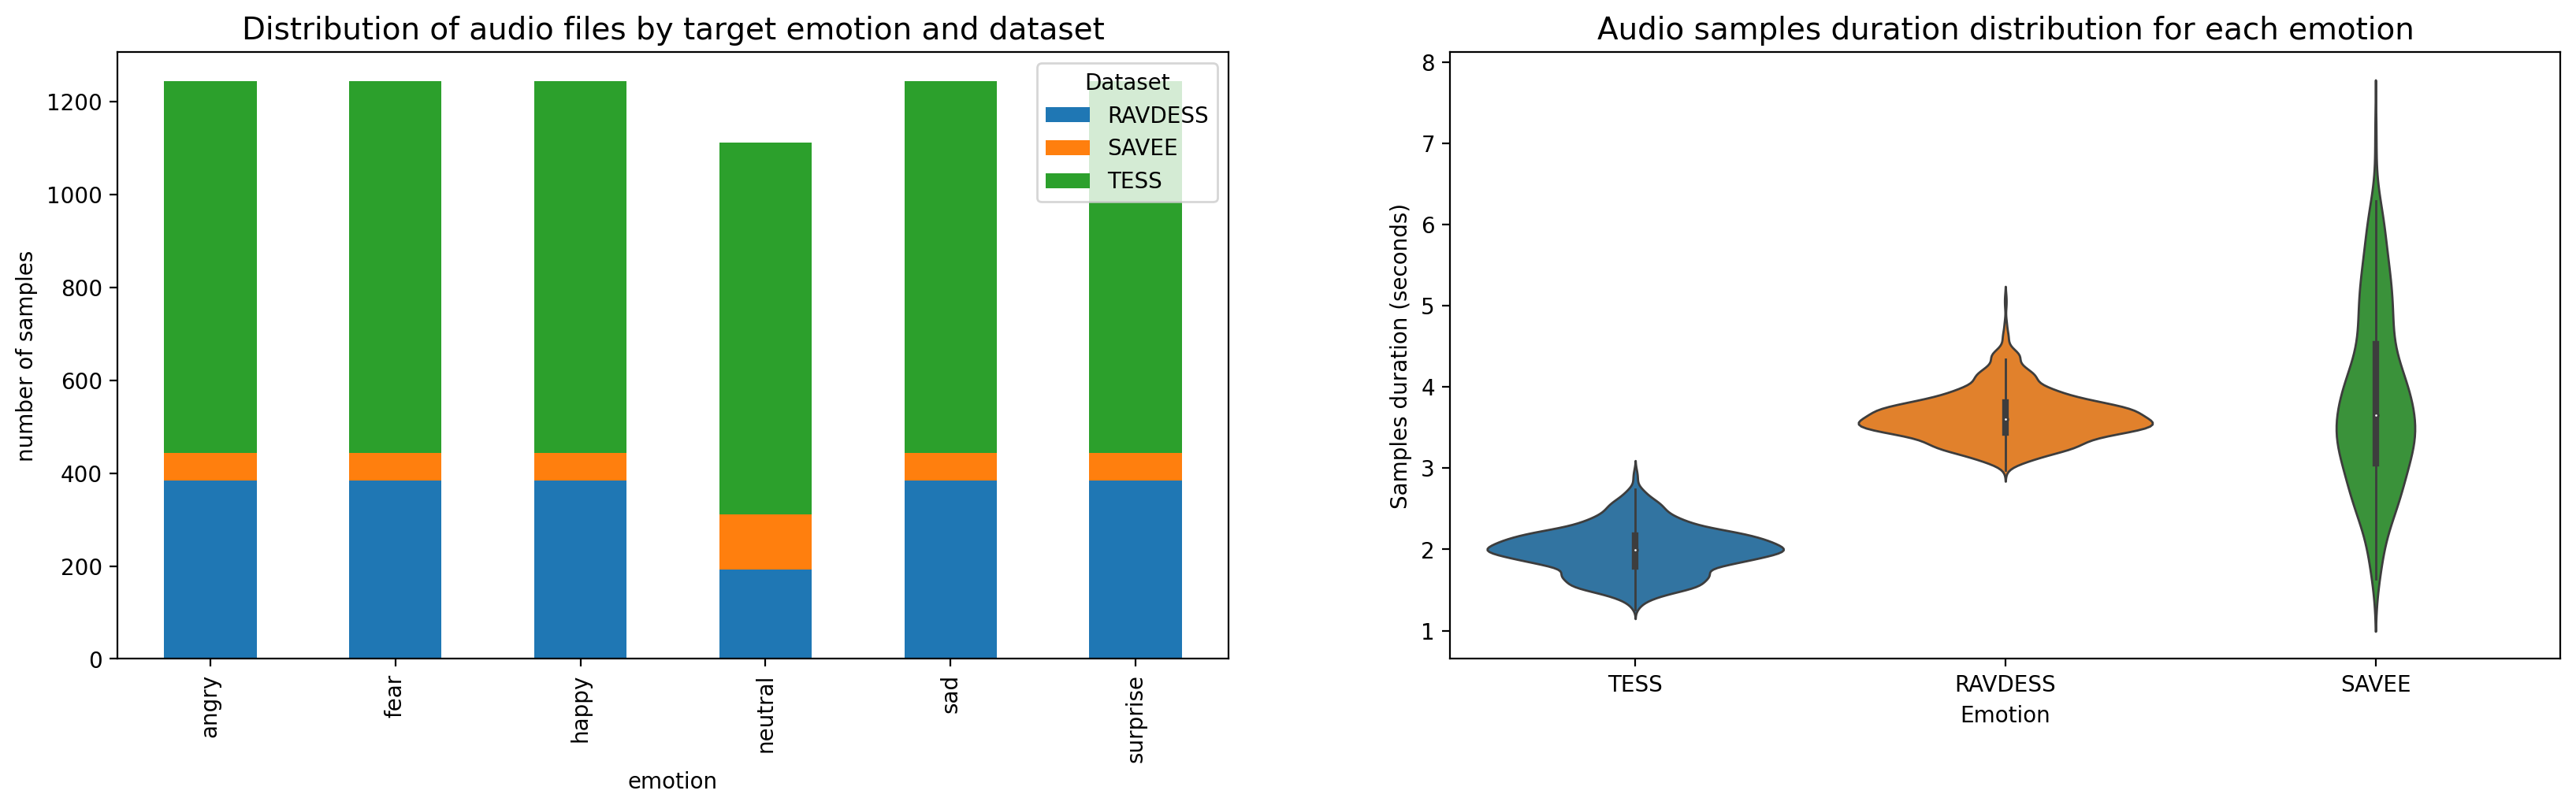

In [7]:
# Creating a figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Check samples distribution
df.groupby(['emotion','dataset']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Distribution of audio files by target emotion and dataset', size=14)
axes[0].set_ylabel('number of samples')
axes[0].legend(title='Dataset')

# Check duration distribution by each source using violin plots
sns.violinplot(x=df['dataset'],y=df['duration'], linewidth=1, ax=axes[1])
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Samples duration (seconds)')
axes[1].set_title('Audio samples duration distribution for each emotion', size=14)

plt.show()

We can note that samples distribution is similar for each target, with 1100~1200 files per category. Overall, the samples length is similar across each source.

Finally, now let's look at what is **inside the audio files**, picking some random samples from different targets. In particular I want to check:
- the **waveforms**
- the **spectograms, with the fundamental frequency**
- the **Mel-frequency cepstrum components (MFCCs)**, as "two-dimensional images".
- and of course hear how they sound, using the built-in **media player** of python

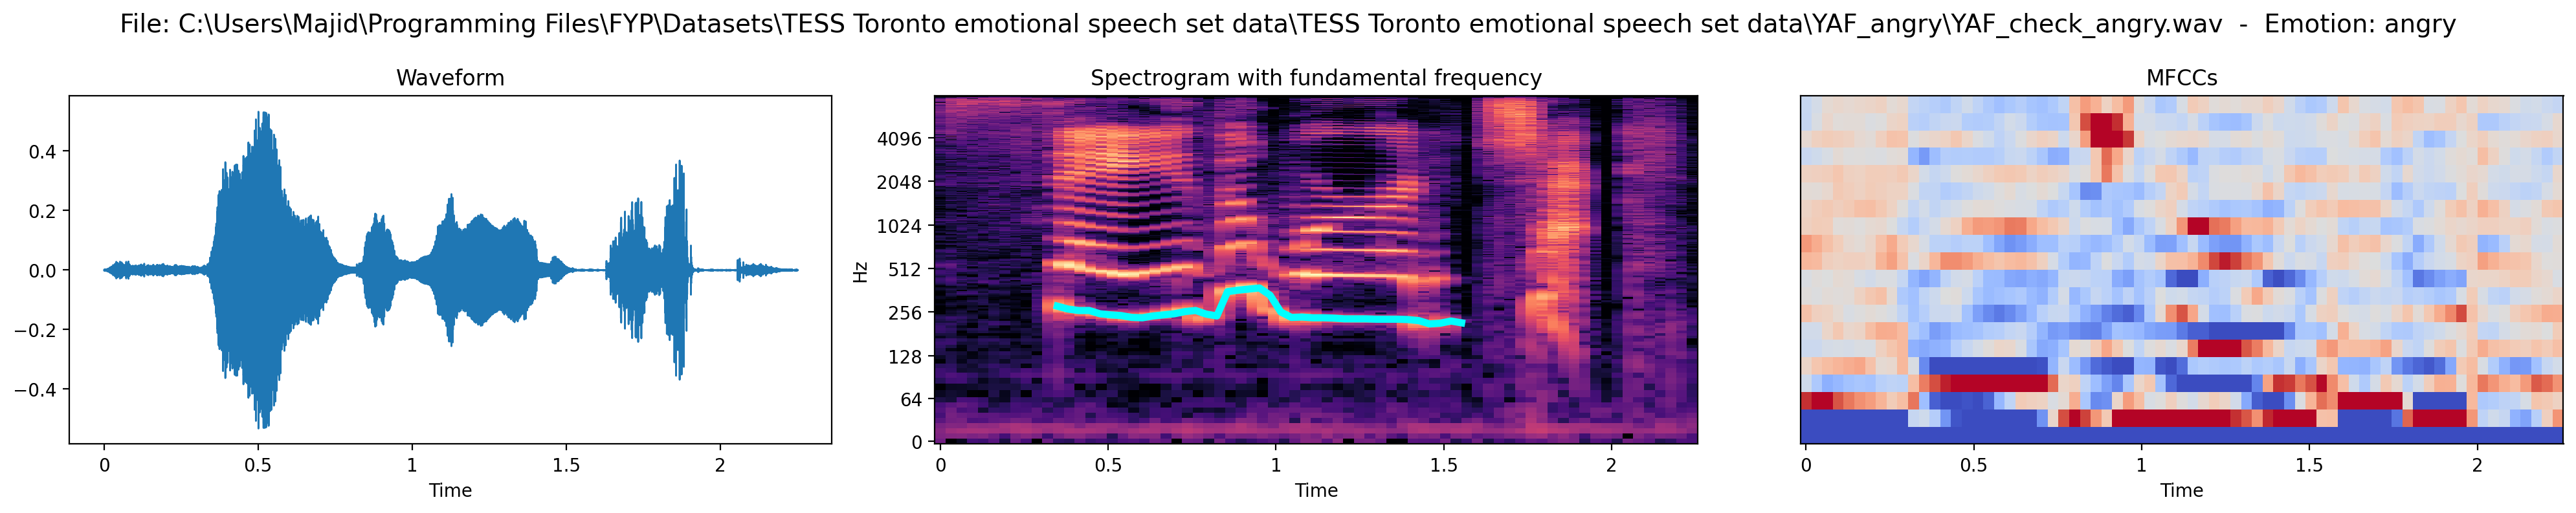

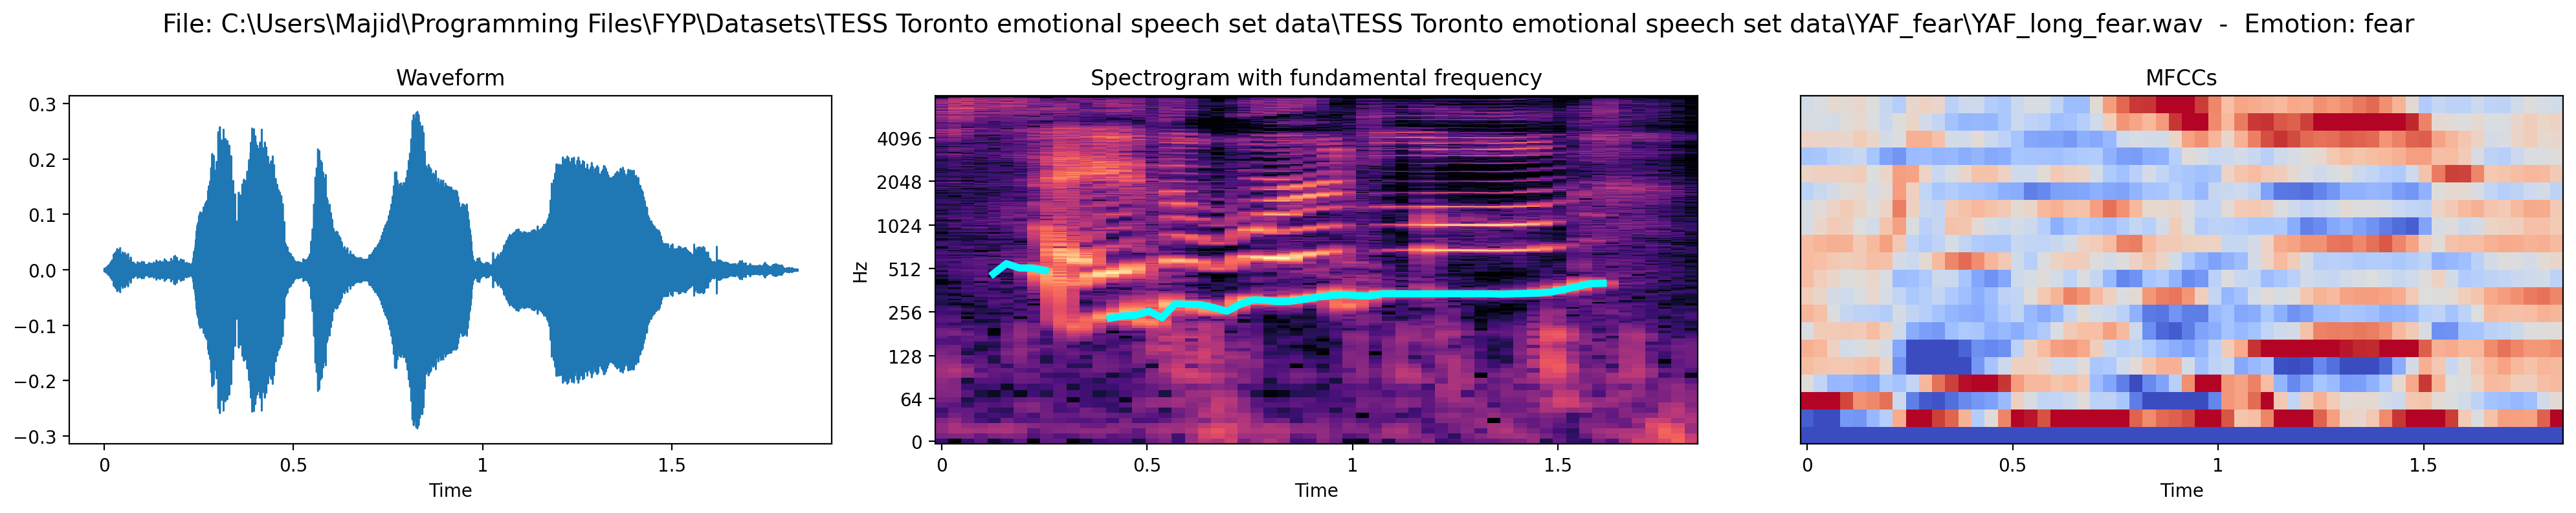

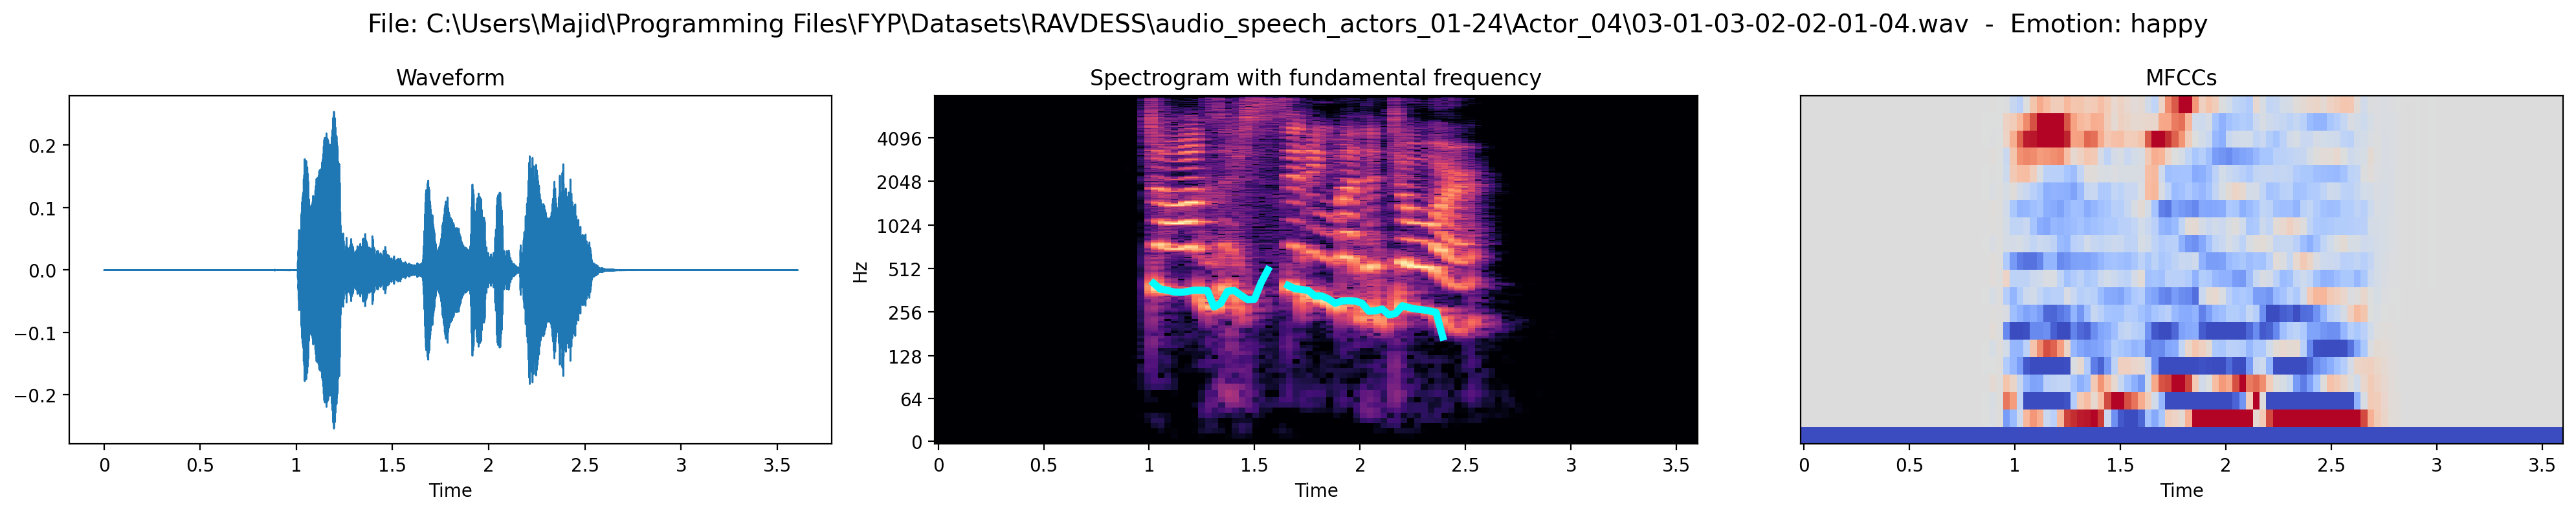

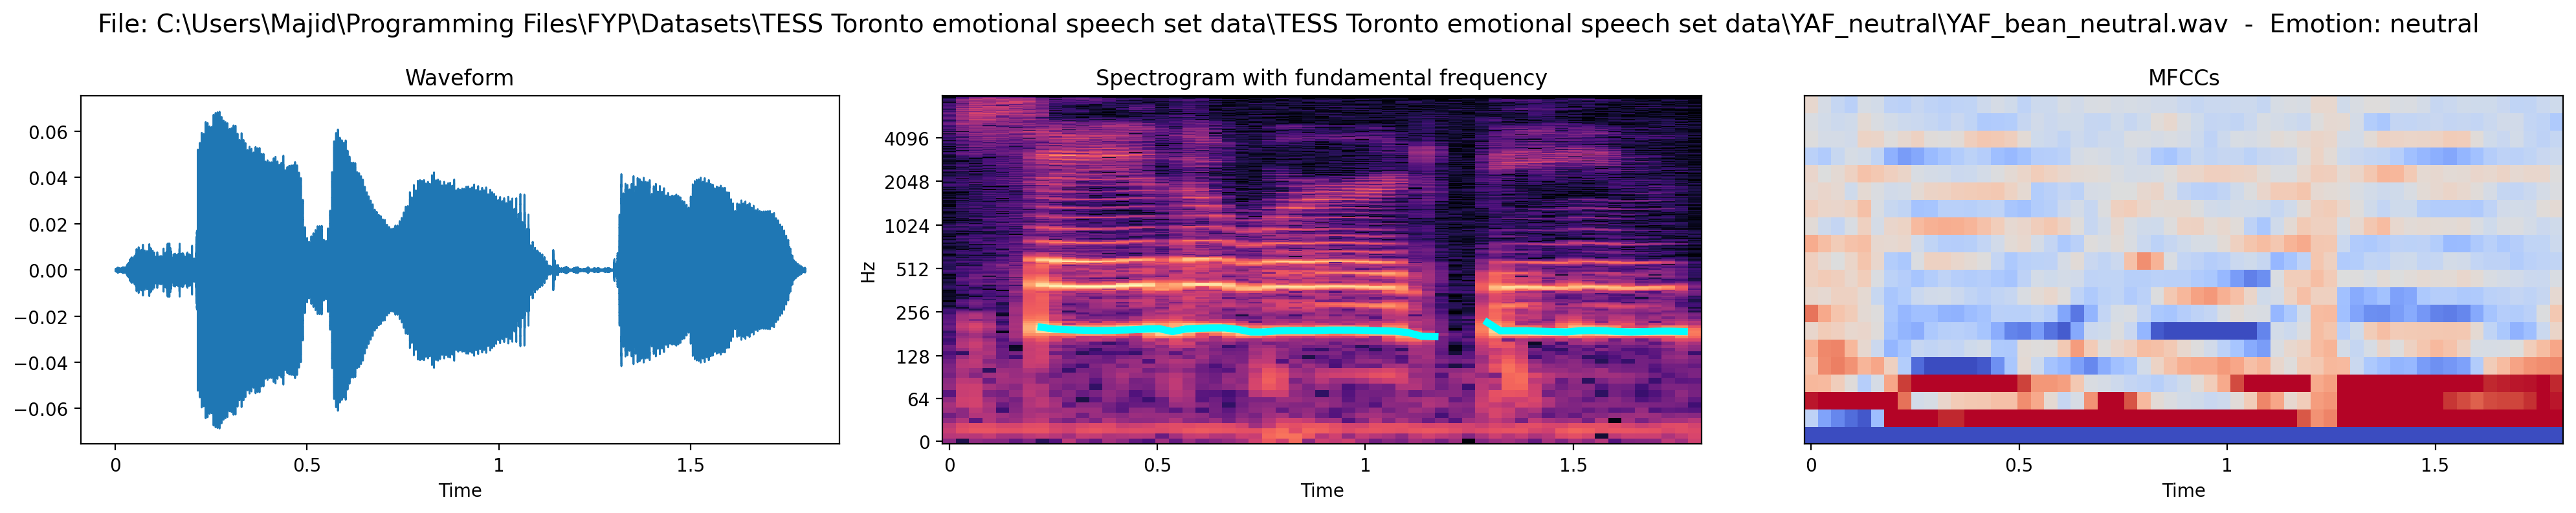

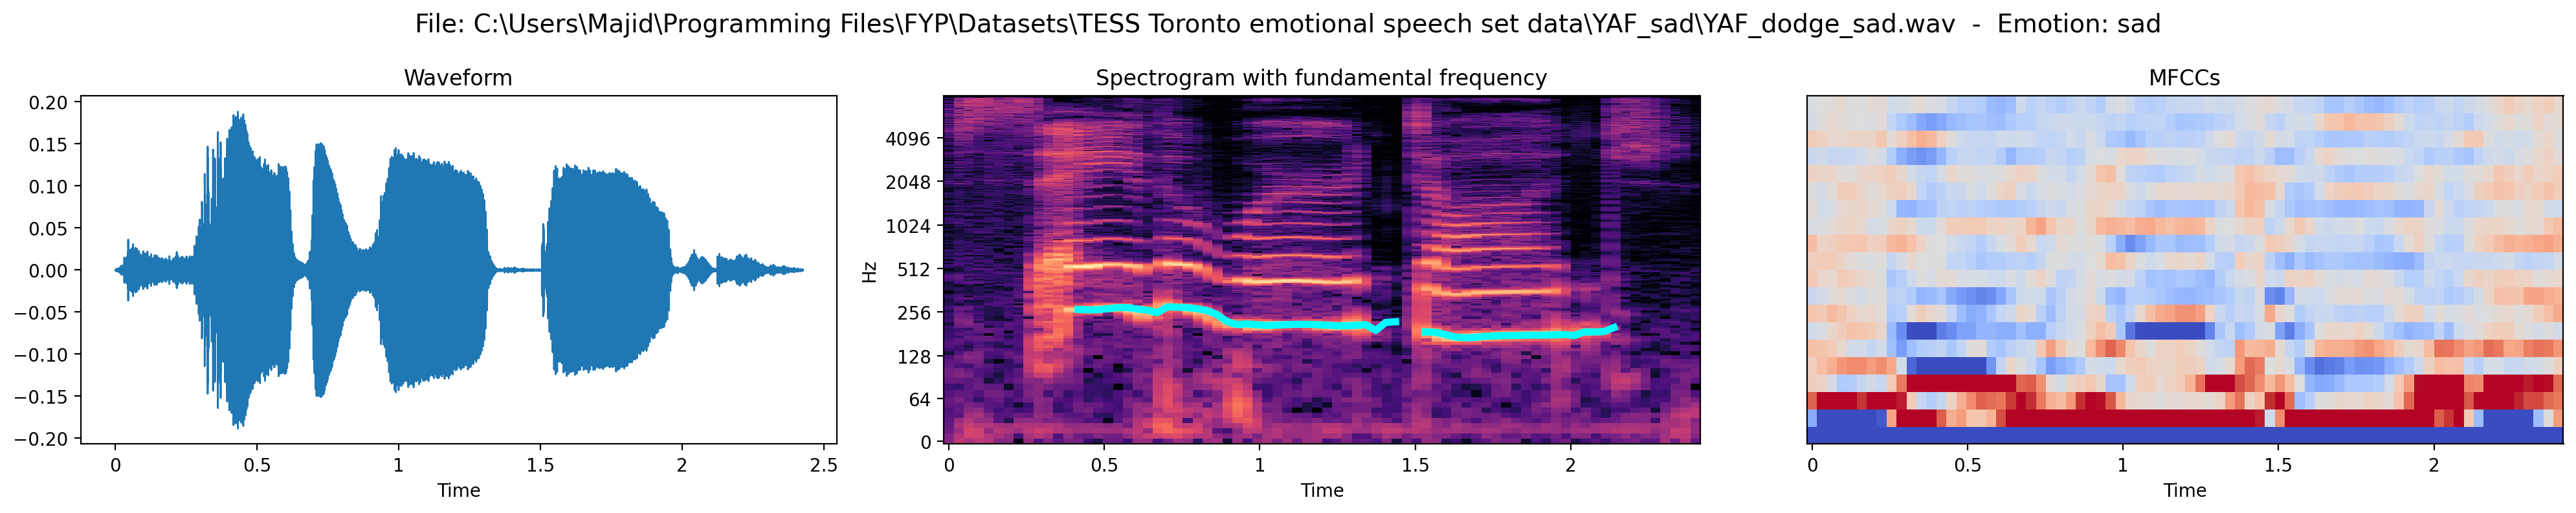

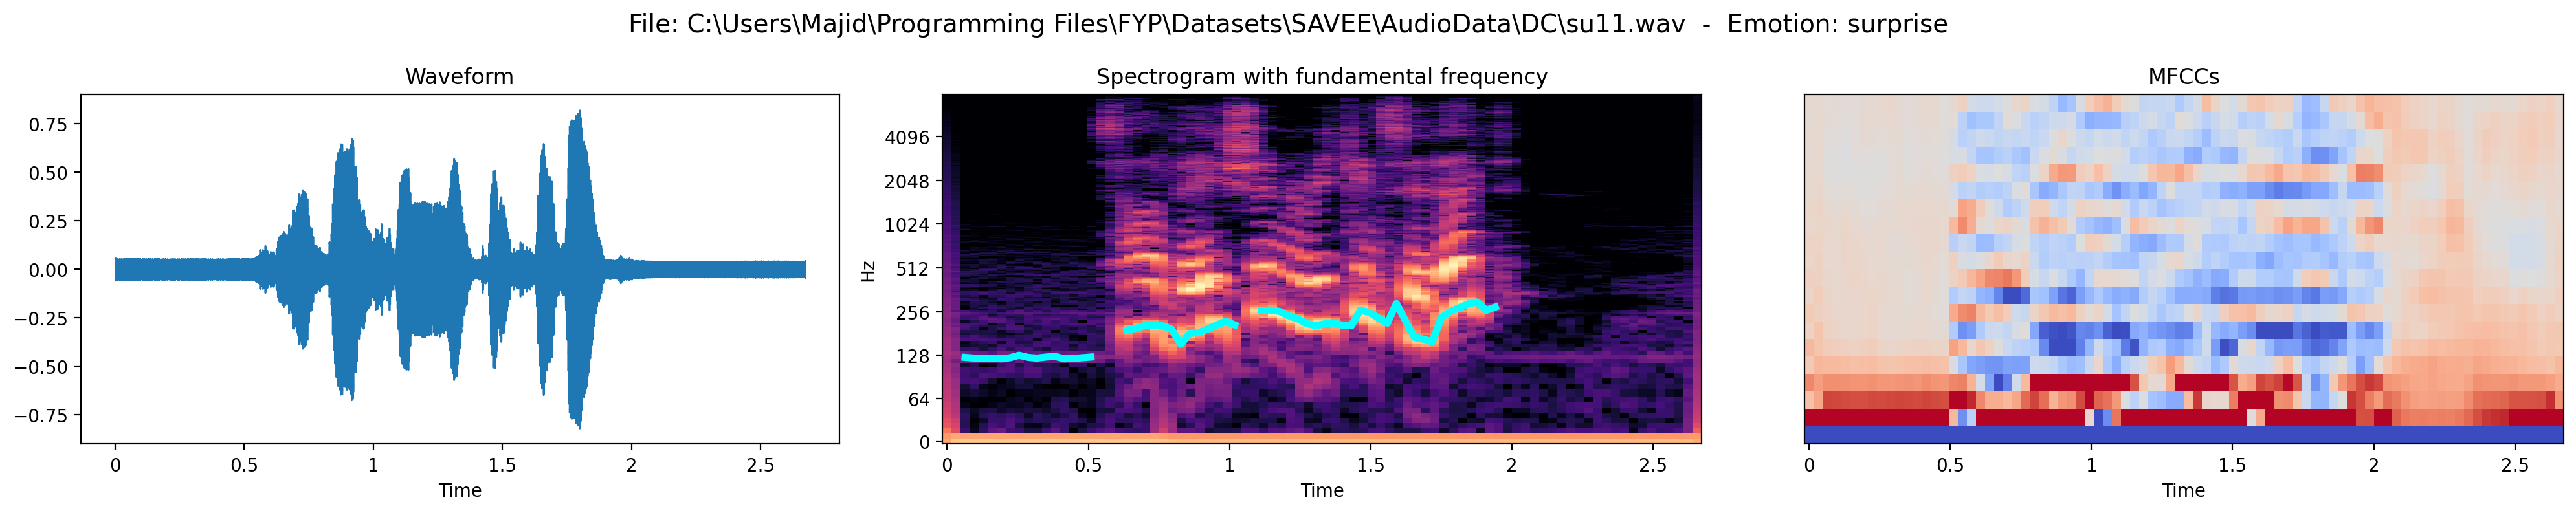

In [8]:
# function to display samples information by emotion
# note that a random samples is generated each time the function is called
# this is on purpose as to check different samples of each emotion every time

def show_audio(emotion):
    # create sublots
    fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
    # filter dataframe to emotion)
    df_show = df.loc[df['emotion'] == emotion].reset_index(drop=True)
    index = random.randint(0, df_show.shape[0])
    
    # load audio file:
    y, sr = librosa.load(df_show.path[index], sr=16000)
    
    # Show waveform
    librosa.display.waveshow(y, sr=sr, ax=axs[0])
    axs[0].set_title('Waveform')
    
    # Extract fundamental frequency (f0) using a probabilistic approach
    f0, _, _ = librosa.pyin(y, sr=sr, fmin=50, fmax=1500, frame_length=2048)

    # Establish timepoint of f0 signal
    timepoints = np.linspace(0, df_show.duration[index], num=len(f0), endpoint=False)
    
    # Compute short-time Fourier Transform
    x_stft = np.abs(librosa.stft(y))
    
    # Apply logarithmic dB-scale to spectrogram and set maximum to 0 dB
    x_stft = librosa.amplitude_to_db(x_stft, ref=np.max)
    
    # Plot STFT spectrogram
    librosa.display.specshow(x_stft, sr=sr, x_axis="time", y_axis="log", ax=axs[1])
    
    # Plot fundamental frequency (f0) in spectrogram plot
    axs[1].plot(timepoints, f0, color="cyan", linewidth=4)
    axs[1].set_title('Spectrogram with fundamental frequency')
    
    # Extract 'n_mfcc' numbers of MFCCs components - in this case 20
    x_mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)

    # Plot MFCCs
    librosa.display.specshow(x_mfccs, sr=sr, x_axis="time", norm=Normalize(vmin=-50, vmax=50), ax=axs[2])
    axs[2].set_title('MFCCs')
    
    # Show metadata in title
    plt.suptitle('File: {}  -  Emotion: {}'.format(df_show.path[index], df_show.emotion[index]), size=14)
    plt.tight_layout()
    plt.show()
    
    # Display media player for the selected file
    display(ipd.Audio(y, rate=sr))

# Getting ordered list of emotions ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emotions = sorted(list(df.emotion.unique()))

# Get waveforms, spectrograms, MFCCs, and media player for each emotion
for emotion in emotions:
    show_audio(emotion)


### Getting MFCCs

For a proper modeling, the audio samples should be trimmed (i.e., removing initial and ending silences), and get some tailored noise reduction techniques.

However, in this case we will directly extract the MFCCs information from the audio files, as "two-dimensional images".

I chose to obtain 30 components for each sample, which will create a 2D arrays with the sound characteristics of the files. This operation may require some time.

In [9]:
%%time

# Create a variable to store the mfccs data
mfccs = []

for file in df.path:
    # load audio file:
    y, sr = librosa.load(file, sr=16000)
    
    # Extract 'n_mfcc' numbers of MFCCs components - in this case 30
    mfccs.append(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=30))


CPU times: total: 9.2 s
Wall time: 48 s


Since the samples have different durations, we need to reshape these two-dimensional arrays in order to feed correctly the convolutional model. For this reason, I apply a function to have the files to the same shape of 30x150, which corresponds to about 4.5 seconds of audio. This also means that files that are shorter will have an additional silent part to reach this threshold (zeros padding), while longer files will be cut off.

In [10]:
# Define function to resize the 2D arrays
def resize_array(array):
    new_matrix = np.zeros((30,150))   # Initialize the new matrix shape with an array 30X150 of zeros
    for i in range(30):               # Iterate rows
        for j in range(150):          # Iterate columns
            try:                                 # the mfccs of a sample will replace the matrix of zeros, then cutting the array up to 150
                new_matrix[i][j] = array[i][j]
            except IndexError:                   # if mfccs of a sample is shorter than 150, then keep looping to extend lenght to 150 with 0s
                pass
    return new_matrix

# Create a variable to store the new resized mfccs and apply function for all the extracted mfccs
resized_mfccs = []

for mfcc in mfccs:
    resized_mfccs.append(resize_array(mfcc))

Let's visualize few MFCCs with the new shape:

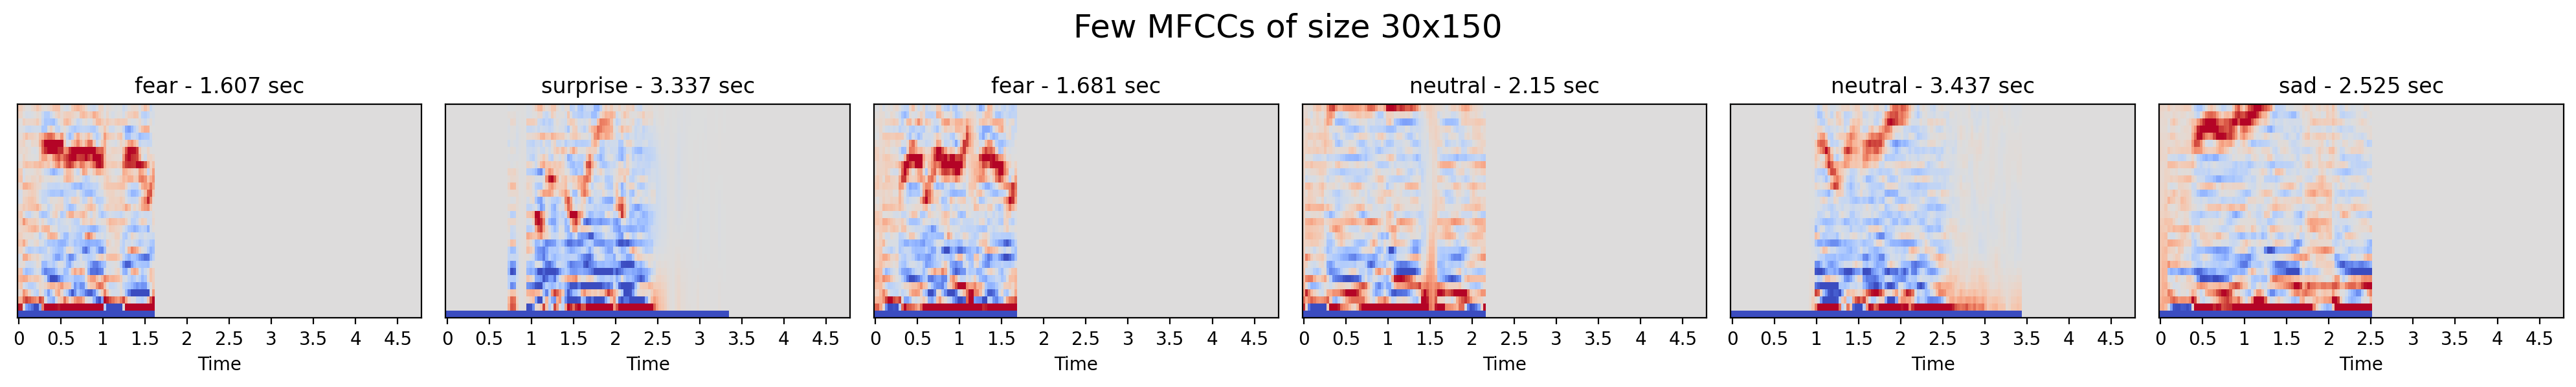

In [11]:
# Create sublots
fig, axs = plt.subplots(nrows=1,ncols=6, figsize=(20,3))

# Select 6 random MFCCs
for i in range(6):
    index = random.randint(0, len(resized_mfccs))
    
    # Plot MFCCs
    librosa.display.specshow(resized_mfccs[index], sr=sr, x_axis="time", ax=axs[i], norm=Normalize(vmin=-50, vmax=50))
    axs[i].set_title(str(df.emotion[index]) + ' - ' + str(df.duration[index]) + ' sec')

plt.suptitle('Few MFCCs of size 30x150', size=18)
plt.tight_layout()
plt.show()

Great, the reshaping function worked as expected, cutting the MFCC spectrum of the longer samples to ~4.5 seconds and adding silence for the shorter files to reach the same length.

##  Convolutional Neural Network model

Let's split the data into train, validation and test set:

In [12]:
from sklearn.model_selection import train_test_split

# Select target
df['emotion'].replace({'angry':0,'fear':1,'happy':2,'neutral':3,'sad':4,'surprise':5}, inplace=True)
y = df.emotion.values

# Features
X = resized_mfccs.copy()

# Create train, validation and test set
x_tr, x_te, y_tr, y_te = train_test_split(X, y, train_size=0.3, shuffle=True, random_state=0)
x_tr, x_va, y_tr, y_va = train_test_split(x_tr, y_tr, test_size=0.7, shuffle=True, random_state=0)

# Convert data to numpy arrays
x_tr = np.array([i for i in x_tr])
x_va = np.array([i for i in x_va])
x_te = np.array([i for i in x_te])

# Plot size of data
print(x_tr.shape)
print(x_va.shape)
print(x_te.shape)

(659, 30, 150)
(1540, 30, 150)
(5133, 30, 150)


The data also should be scaled in order to be used properly in a convolutional neural network. This transformation can be done manually by applying the mean and standard deviation from the training set also to the other sets.

In [13]:
# Get mean and standard deviation from the training set
tr_mean = np.mean(x_tr, axis=0)
tr_std = np.std(x_tr, axis=0)

# Apply data scaling
x_tr = (x_tr - tr_mean)/tr_std
x_va = (x_va - tr_mean)/tr_std
x_te = (x_te - tr_mean)/tr_std

Another necessary operation is to add another 'dimension' to the data:

In [14]:
# Add the 'channel' dimension to the MFCCs spectrum input 'images'
print(f"x_tr has a dimension of {x_tr.shape} before the manipulation.")

x_tr = x_tr[..., None]
x_va = x_va[..., None]
x_te = x_te[..., None]

print(f"x_tr has a dimension of {x_tr.shape} after the manipulation.")

x_tr has a dimension of (659, 30, 150) before the manipulation.
x_tr has a dimension of (659, 30, 150, 1) after the manipulation.


In [15]:
x_tr = np.resize(x_tr, (len(x_tr), 30, 150, 1))
x_va = np.resize(x_va, (len(x_va), 30, 150, 1))
x_te = np.resize(x_te, (len(x_te), 30, 150, 1))

Let's define the Convolutional Neural Network model using Tensorflow:

In [16]:
%%time

from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D)
from tensorflow.keras import initializers

# Create convolutional neural network and return summary
model = keras.Sequential()
model.add(Conv2D(filters=64, kernel_size=5, strides=(2, 2), activation="relu", input_shape=x_tr.shape[1:]))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=4, strides=(2, 1), activation="relu"))
model.add(MaxPool2D(pool_size=2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(units=7, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 73, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 36, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 6, 36, 64)        256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 33, 32)         32800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 16, 32)        0         
 2D)                                                             
                                                        

Before fitting the model I will provide an EarlyStopping callback function.

In [17]:
# Compile the model using Adam's default learning rate
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Create 'EarlyStopping' callback
earlystopping_cb = keras.callbacks.EarlyStopping(patience=5)

In [18]:
%%time

#  Train the neural network
history = model.fit(
    x=x_tr,
    y=y_tr,
    epochs=100,
    batch_size=32,
    validation_data=(x_va, y_va),
    callbacks=[earlystopping_cb]
)

Epoch 1/100
21/21 [==============================] - 2s 35ms/step - loss: 3.1141 - accuracy: 0.1866 - val_loss: 1.8775 - val_accuracy: 0.2727
Epoch 2/100
21/21 [==============================] - 1s 24ms/step - loss: 2.2190 - accuracy: 0.2595 - val_loss: 1.8442 - val_accuracy: 0.4117
Epoch 3/100
21/21 [==============================] - 0s 24ms/step - loss: 2.0378 - accuracy: 0.3050 - val_loss: 1.7676 - val_accuracy: 0.4935
Epoch 4/100
21/21 [==============================] - 0s 24ms/step - loss: 1.7870 - accuracy: 0.3414 - val_loss: 1.7051 - val_accuracy: 0.4312
Epoch 5/100
21/21 [==============================] - 0s 24ms/step - loss: 1.6216 - accuracy: 0.3991 - val_loss: 1.6385 - val_accuracy: 0.3318
Epoch 6/100
21/21 [==============================] - 0s 24ms/step - loss: 1.5244 - accuracy: 0.4461 - val_loss: 1.5760 - val_accuracy: 0.2695
Epoch 7/100
21/21 [==============================] - 0s 23ms/step - loss: 1.4115 - accuracy: 0.4734 - val_loss: 1.4399 - val_accuracy: 0.4812
Epoch 

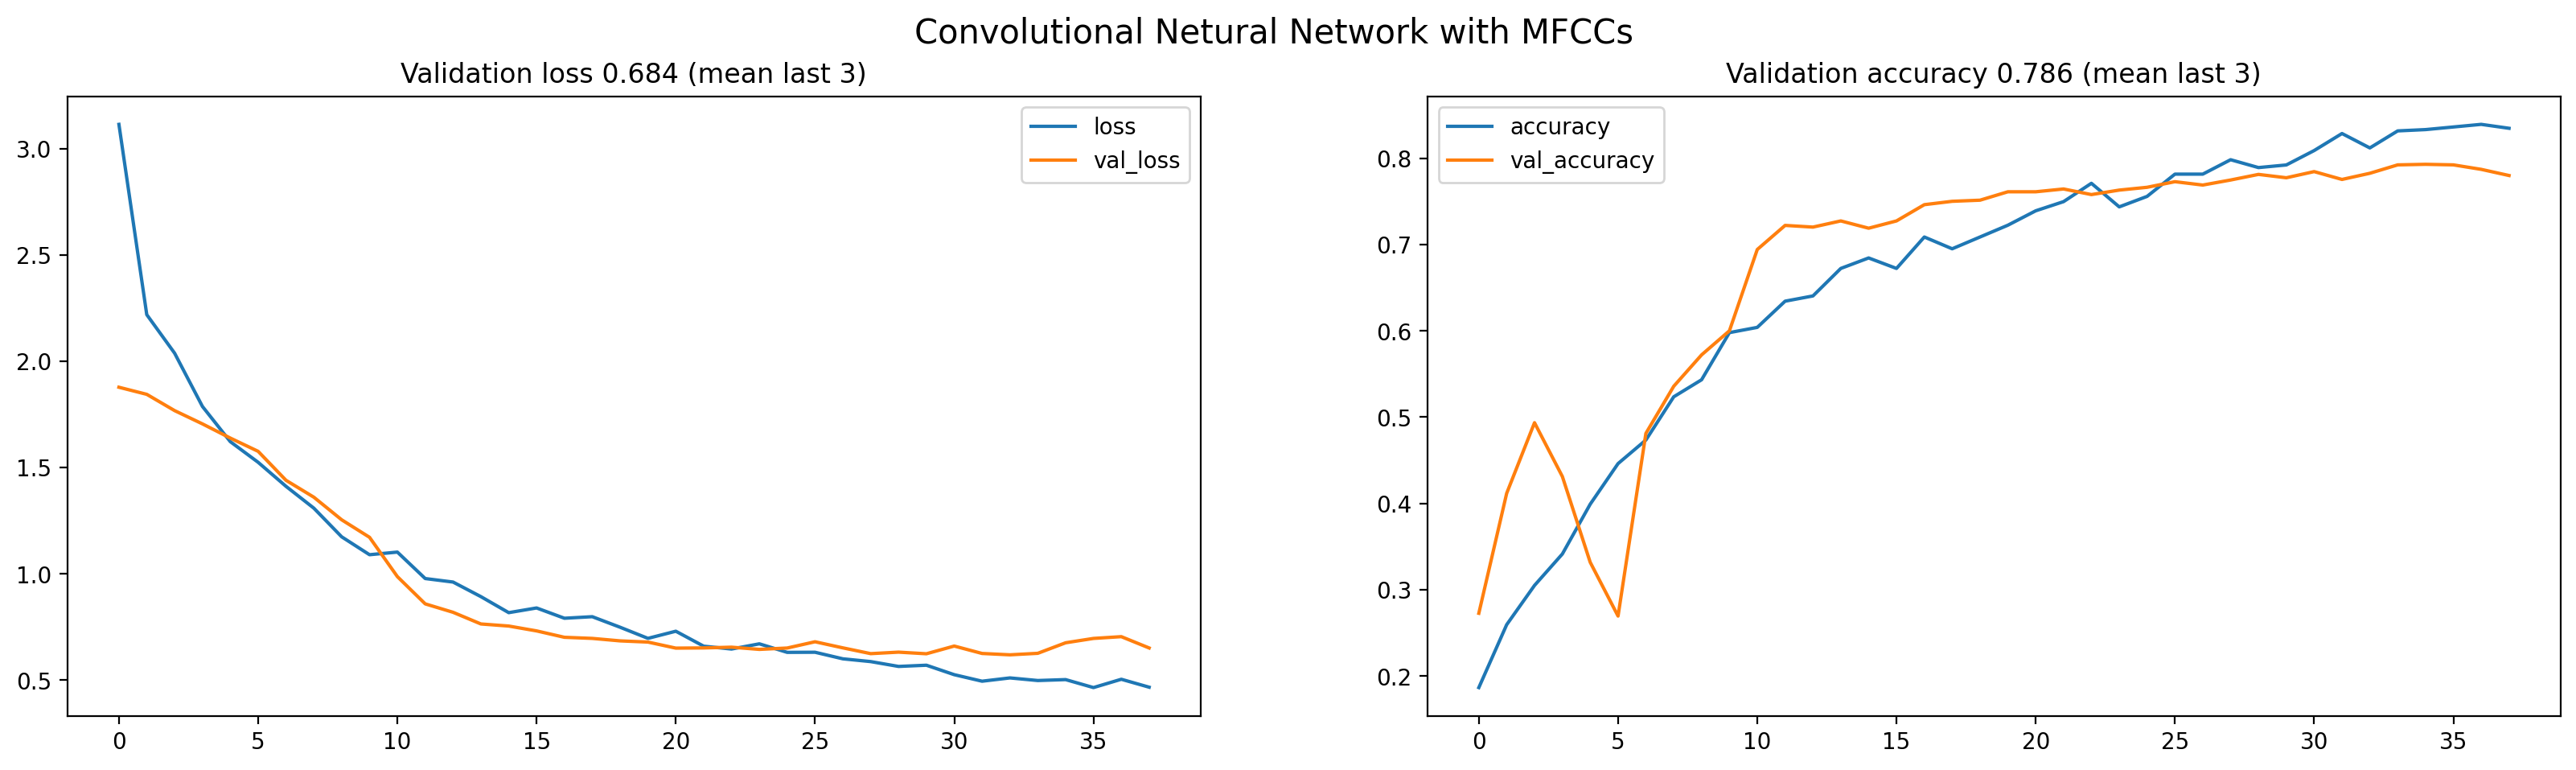

In [19]:
# Plots neural network performance metrics for train and validation
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Convolutional Netural Network with MFCCs', size=15)
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:])))
results[["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(history.history["val_accuracy"][-3:])))
plt.show()

In [20]:
from tensorflow import keras
model.save('my_cnn_model.h5')

The training and validation accuracies are both improving during the first ~30 epochs, then we start to see signals of overfitting.

### Test set evaluation

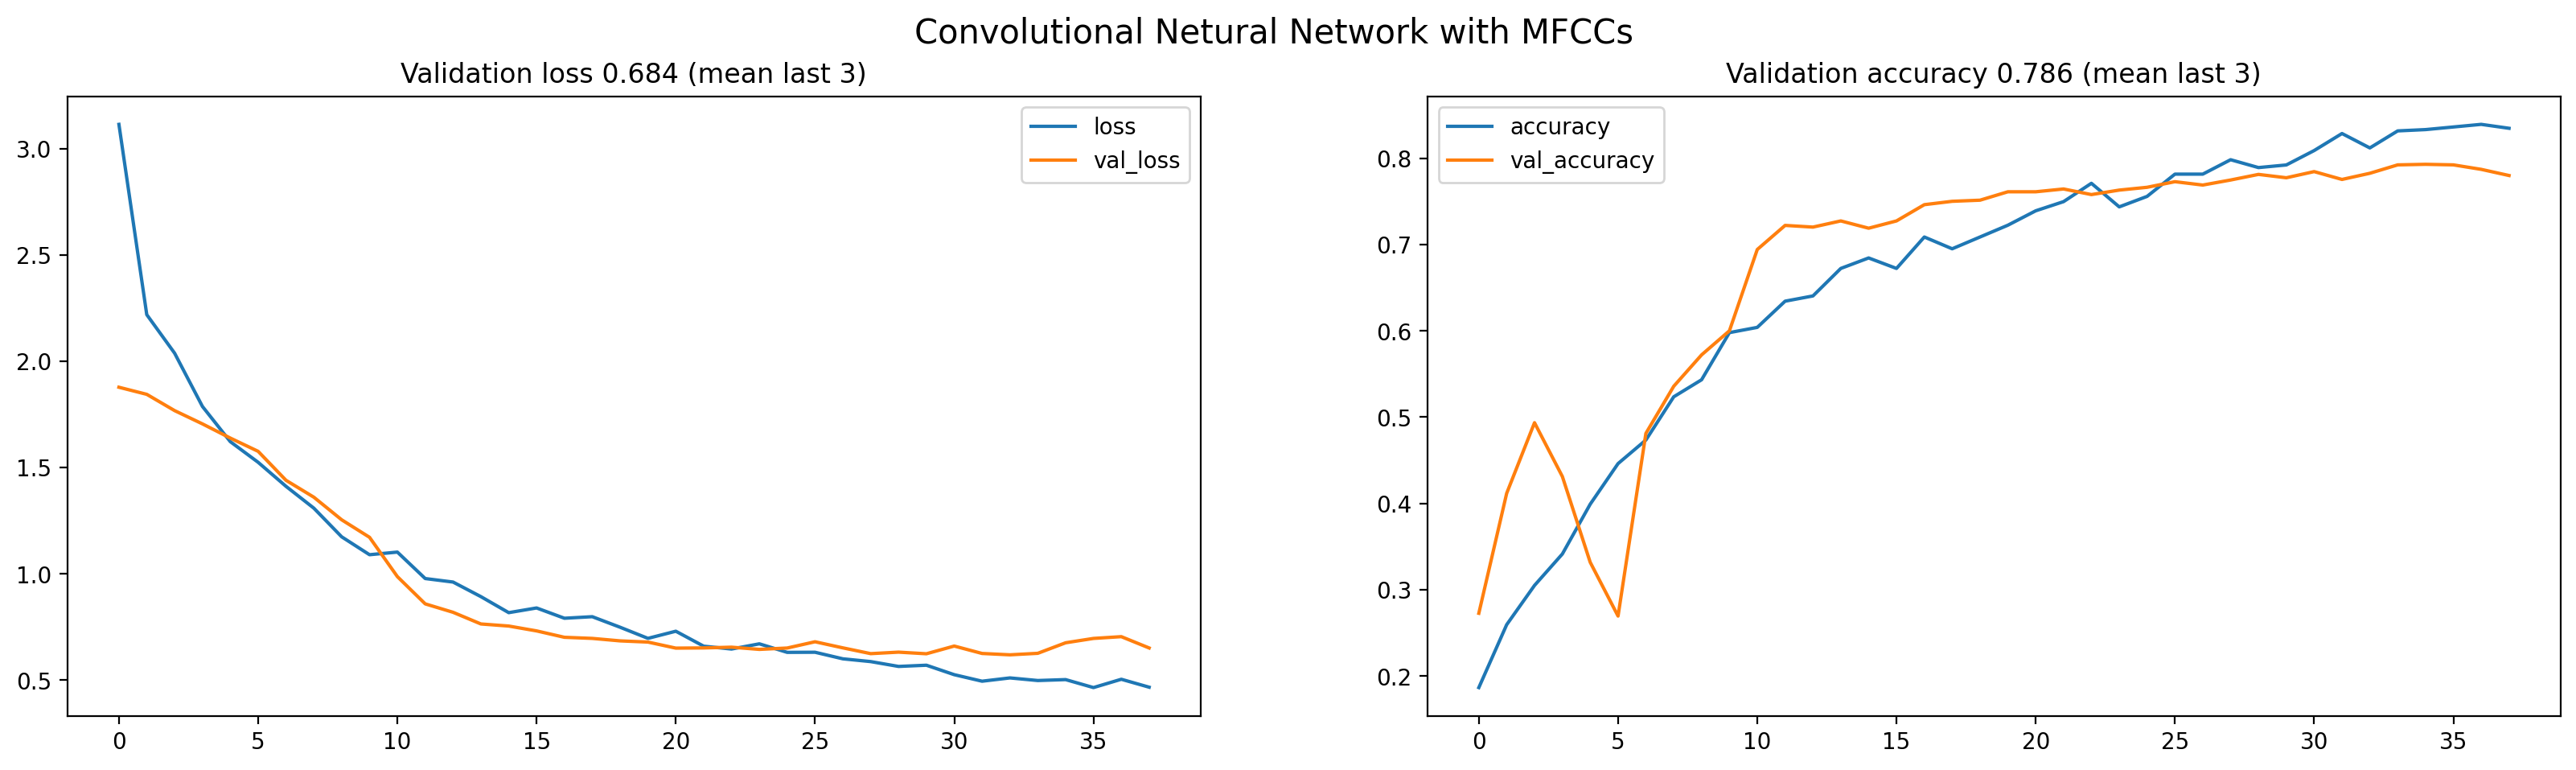

In [21]:
# Plots neural network performance metrics for train and validation
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Convolutional Netural Network with MFCCs', size=15)
results = pd.DataFrame(history.history)
results[["loss", "val_loss"]].plot(ax=axs[0])
axs[0].set_title("Validation loss {:.3f} (mean last 3)".format(np.mean(history.history["val_loss"][-3:])))
results[["accuracy", "val_accuracy"]].plot(ax=axs[1])
axs[1].set_title("Validation accuracy {:.3f} (mean last 3)".format(np.mean(history.history["val_accuracy"][-3:])))
plt.show()

In [22]:
# Collect loss and accuracy for the test set
loss_te, accuracy_te = model.evaluate(x_te, y_te)

print("Test loss: {:.2f}".format(loss_te))
print("Test accuracy: {:.2f}%".format(100 * accuracy_te))

161/161 [==============================] - 1s 4ms/step - loss: 0.6029 - accuracy: 0.8003
Test loss: 0.60
Test accuracy: 80.03%


The accuracy on the test set with this method is 79%.

We can also see the model performance for each target by using a confusion matrix:

161/161 [==============================] - 1s 4ms/step


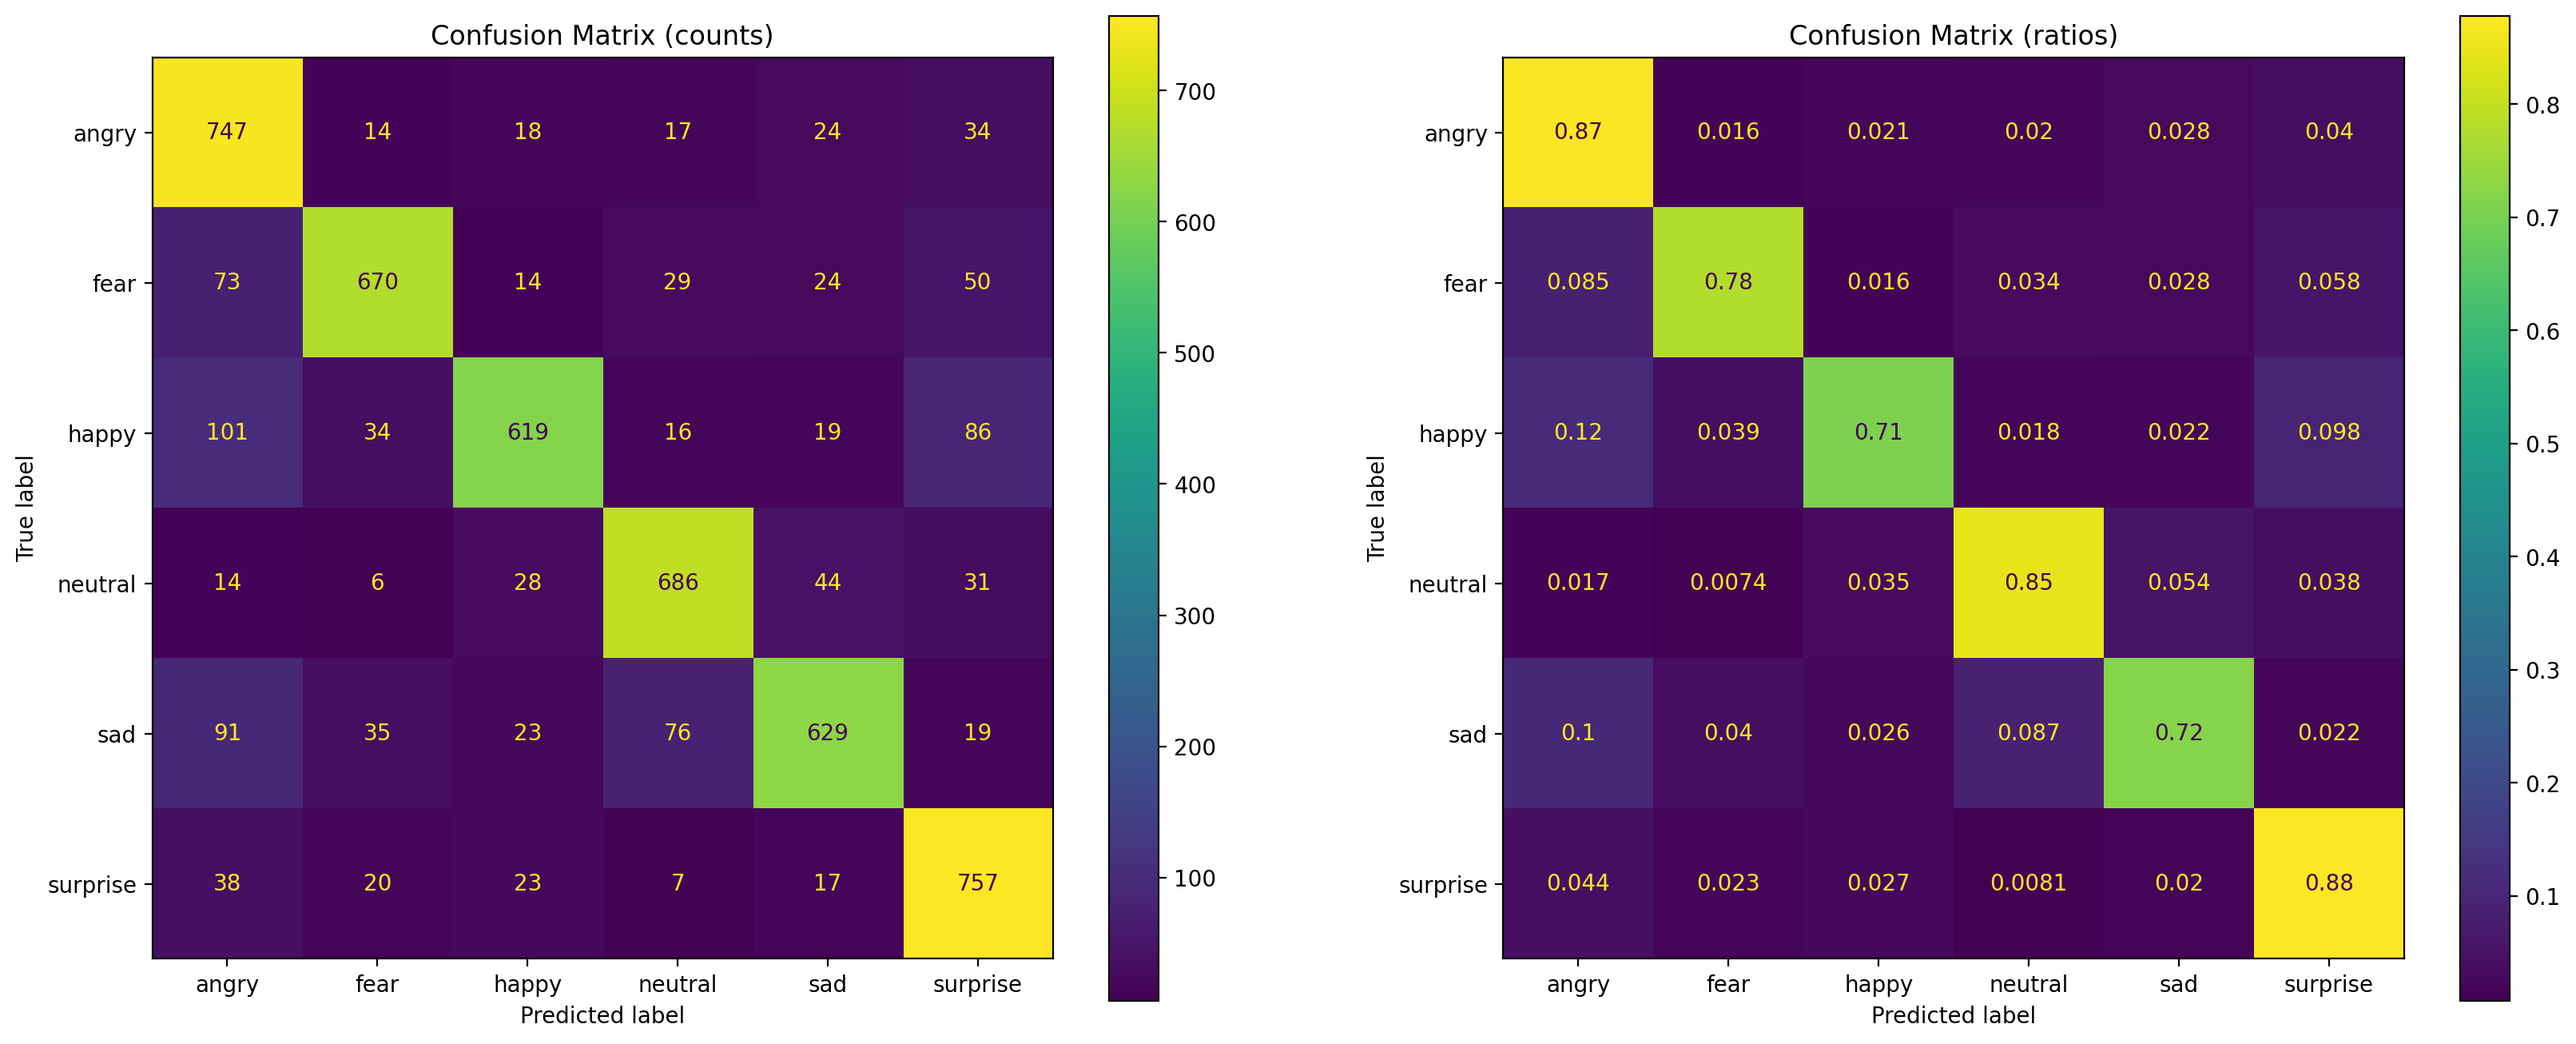

In [23]:
# Compute test set predictions
predictions = model.predict(x_te)

pred = []

for i in predictions:
    pred.append(np.argmax(i))
    
from sklearn.metrics import ConfusionMatrixDisplay

labels = {'angry':0,'fear':1,'happy':2,'neutral':3,'sad':4,'surprise':5}

def plot_confusion_matrices(y_true, y_pred):

    # Create two subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plots the standard confusion matrix
    ax1.set_title("Confusion Matrix (counts)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, ax=ax1)

    # Plots the normalized confusion matrix
    ax2.set_title("Confusion Matrix (ratios)")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, normalize="true", ax=ax2)

    plt.show()

# Plot confusion matrices
plot_confusion_matrices(y_te, pred)

In [24]:
#Test

def detect_emotion(audio_file):
    # Load the audio file and extract MFCCs
    y, sr = librosa.load(audio_file, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=30)
    
    # Resize and scale the MFCCs
    resized_mfccs = resize_array(mfccs)
    scaled_mfccs = (resized_mfccs - tr_mean) / tr_std
    scaled_mfccs = np.resize(scaled_mfccs, (1, 30, 150, 1))
    
    # Predict the emotion using the trained model
    prediction = model.predict(scaled_mfccs)
    emotion_index = np.argmax(prediction)
    
    # Map the emotion index back to the original labels
    emotion_mapping = {0: 'angry', 1: 'fear', 2: 'happy', 3: 'neutral', 4: 'sad', 5: 'surprise'}
    predicted_emotion = emotion_mapping[emotion_index]
    
    return predicted_emotion


In [43]:
# Record audio from user

CHUNK = 1024 
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2 
RATE = 44100 #sample rate
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "voice_input.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


In [46]:
audio_file = 'C:\\Users\\Majid\\Programming Files\\FYP\\voice_input.wav'
predicted_emotion = detect_emotion(audio_file)
print("Predicted emotion:", predicted_emotion)

1/1 [==============================] - 0s 22ms/step
Predicted emotion: happy


In [27]:
song_info = pd.read_csv("C:\\Users\Majid\\Programming Files\\FYP\\Datasets\\EMO_Dataset\\annotations\\static_annotations.csv")
song_info.head(20)

,song_id,mean_arousal,std_arousal,mean_valence,std_valence
0,2,3.1,0.99443,3.0,0.66667
1,3,3.5,1.84090,3.3,1.70290
2,4,5.7,1.49440,5.5,1.71590
3,5,4.4,2.11870,5.3,1.94650
4,7,5.8,1.54920,6.4,1.77640
5,8,3.2,1.47570,4.8,1.61930
6,10,4.0,1.76380,4.7,1.94650
7,12,5.5,2.01380,5.8,1.98890
8,13,3.2,1.47570,4.0,1.76380
9,17,4.4,1.89740,6.0,2.16020


In [28]:
static_df = song_info.drop(columns=['std_arousal', 'std_valence'])

static_df.head()

,song_id,mean_arousal,mean_valence
0,2,3.1,3.0
1,3,3.5,3.3
2,4,5.7,5.5
3,5,4.4,5.3
4,7,5.8,6.4


In [29]:
min_arousal = static_df["mean_arousal"].min()
max_arousal = static_df["mean_arousal"].max()
min_valence = static_df["mean_valence"].min()
max_valence = static_df["mean_valence"].max()

# Normalize the arousal and valence values to range from -1 to 1
static_df["norm_arousal"] = (static_df["mean_arousal"] - min_arousal) / (max_arousal - min_arousal) * 2 - 1
static_df["norm_valence"] = (static_df["mean_valence"] - min_valence) / (max_valence - min_valence) * 2 - 1

In [30]:
static_df.sample(12)

,song_id,mean_arousal,mean_valence,norm_arousal,norm_valence
474,613,5.2,6.8,0.058824,0.600000
23,41,4.3,5.1,-0.205882,0.076923
550,710,5.4,5.1,0.117647,0.076923
697,932,4.5,4.9,-0.147059,0.015385
377,456,6.1,2.3,0.323529,-0.784615
556,717,4.5,4.9,-0.147059,0.015385
700,938,7.3,4.2,0.676471,-0.200000
406,493,3.7,4.9,-0.382353,0.015385
409,497,6.2,5.7,0.352941,0.261538
602,780,5.8,6.2,0.235294,0.415385


In [31]:
def define_emotion(norm_arousal	, norm_valence):
    # Define emotions dictionary
    emotions = {
        (1, 1): "Happy",
        (1, 0): "Energetic",
        (0, 1): "Peaceful",
        (-1, -1): "Sad",
        (-1, 0): "Relaxed",
        (0, -1): "Calm",
        (1, -1): "Excited",
        (-1, 1): "Serious"
    }

    # Check if arousal and valence values are within range
    if norm_arousal > 1 or norm_arousal < -1 or norm_valence > 1 or norm_valence < -1:
        return "Invalid values"

    # Determine the emotion based on the arousal and valence values
    for key in emotions.keys():
        if key[0] == round(norm_arousal) and key[1] == round(norm_valence):
            return emotions[key]

    return "Undefined"

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Add 'emotion' column
static_df['emotion'] = static_df.apply(lambda x: define_emotion(x['norm_arousal'], x['norm_valence']), axis=1)

# Split data into train and test sets
X = static_df[['norm_arousal', 'norm_valence']]
y = static_df['emotion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create k-NN classifier
k = 7
knn = KNeighborsClassifier(n_neighbors=k)

# Fit the classifier to the training data
knn.fit(X_train, y_train)

# Predict the emotions of the test set using the trained classifier
song_emotion = knn.predict(X_test)

# Create a new DataFrame with the predicted emotions
predicted_df = X_test.copy()
predicted_df['predicted_emotion'] = song_emotion

# Print the updated DataFrame with predicted emotions
print(predicted_df)

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, song_emotion)
print(f"Accuracy: {accuracy}")

     norm_arousal  norm_valence predicted_emotion
609     -0.676471     -0.076923           Relaxed
539     -0.058824      0.292308         Undefined
694     -0.294118      0.200000         Undefined
350     -0.147059      0.169231         Undefined
174     -0.058824     -0.015385         Undefined
..            ...           ...               ...
404     -0.323529     -0.353846         Undefined
69       0.235294     -0.046154         Undefined
712      0.147059      0.076923         Undefined
131      0.382353     -0.415385         Undefined
44       0.411765      0.292308         Undefined

[149 rows x 3 columns]
Accuracy: 0.9328859060402684


In [33]:
static_df['emotion']

0            Sad
1      Undefined
2      Undefined
3      Undefined
4      Undefined
         ...    
739         Calm
740     Peaceful
741     Peaceful
742    Undefined
743    Energetic
Name: emotion, Length: 744, dtype: object

In [34]:
# Number of unique values
num_unique_values = static_df['emotion'].nunique()
print(f"Number of unique values in 'emotion': {num_unique_values}")

# List of unique values
list_unique_values = static_df['emotion'].unique()
print(f"Unique values in 'emotion': {list_unique_values}")

undefined_count = predicted_df[predicted_df['predicted_emotion'] == 'Undefined'].shape[0]
print(f"Number of instances classified as 'Undefined': {undefined_count}")


Number of unique values in 'emotion': 8
Unique values in 'emotion': ['Sad' 'Undefined' 'Relaxed' 'Peaceful' 'Energetic' 'Calm' 'Happy'
 'Excited']
Number of instances classified as 'Undefined': 102


In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

# Make predictions on the testing set
y_pred = knn.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1)

# Tune hyperparameters using grid search
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

Accuracy: 0.9328859060402684
Precision: 0.8970430277374107
Recall: 0.8225218658892127
F1 score: 0.8365419265419265
Best hyperparameters: {'n_neighbors': 7}


In [36]:
model_filename = 'knn_model.joblib'
joblib.dump(knn, model_filename)

['knn_model.joblib']

In [37]:
#load models 
cnn_model = keras.models.load_model("my_cnn_model.h5") #SER
knn_model_file = "knn_model.joblib" #Emotion based MRS

In [38]:
static_df

,song_id,mean_arousal,mean_valence,norm_arousal,norm_valence,emotion
0,2,3.1000,3.0000,-0.558824,-0.569231,Sad
1,3,3.5000,3.3000,-0.441176,-0.476923,Undefined
2,4,5.7000,5.5000,0.205882,0.200000,Undefined
3,5,4.4000,5.3000,-0.176471,0.138462,Undefined
4,7,5.8000,6.4000,0.235294,0.476923,Undefined
...,...,...,...,...,...,...
739,995,4.7000,2.4000,-0.088235,-0.753846,Calm
740,996,6.0000,6.7000,0.294118,0.569231,Peaceful
741,997,6.4000,6.7000,0.411765,0.569231,Peaceful
742,999,4.1000,5.9000,-0.264706,0.323077,Undefined


In [39]:
def query_by_emotion(emotion):
    # Filter the dataset to retrieve songs with the specified emotion
    matched_songs = static_df[static_df['emotion'] == emotion]
    
    # Return the DataFrame of matched songs
    return matched_songs

In [41]:
def query_by_emotion(emotion):
    # Filter the dataset to retrieve songs with the specified emotion
    matched_songs = static_df[static_df['emotion'] == emotion]
    
    # Return the DataFrame of matched songs
    return matched_songs

def generate_playlist(audio_file):
    # Step 1: Perform emotion detection using the audio file
    predicted_emotion = detect_emotion(audio_file)
    print("Detected emotion:", predicted_emotion)

    # Step 2: Determine the desired emotion for song recommendation
    if predicted_emotion == "fear":
        desired_emotion = "Peaceful"
    elif predicted_emotion == "angry":
        desired_emotion = "Calm"
    elif predicted_emotion == "sad":
        desired_emotion = "Sad"
    elif predicted_emotion == "happy":
        desired_emotion = "Happy"
    elif predicted_emotion == "neutral":
        desired_emotion = "Energetic"
    else:
        desired_emotion = predicted_emotion
    
    # Step 3: Find songs that match the desired emotion using the KNN model
    matched_songs = query_by_emotion(desired_emotion)

    if matched_songs.empty:
        print("No songs found with the desired emotion.")
        return

    # Step 4: Recommend top 10 songs based on specific criteria (e.g., mean_arousal, mean_valence)
    recommended_songs = matched_songs.sort_values(['mean_arousal', 'mean_valence'], ascending=False)[:10]

    # Step 5: Print recommended songs
    print('Recommended songs:')
    for index, row in recommended_songs.iterrows():
        print(row['song_id'])

# Example usage
if __name__ == "__main__":
    audio_file = "voice_input.wav"
    generate_playlist(audio_file)


1/1 [==============================] - 0s 49ms/step
Detected emotion: sad
Recommended songs:
708
707
215
579
2
565
367
711
498
478


In [42]:
songdetails = pd.read_csv("C:\\Users\Majid\\Programming Files\\FYP\\Datasets\\EMO_Dataset\\annotations\\songs_info.csv")
songdetails

,song_id,file_name,Artist,Song title,start of the segment (min.sec),end of the segment (min.sec),Genre,Mediaeval 2013 set
0,2,\t2.mp3,The New Mystikal Troubadours\t,\tTonight A Lonely Century\t,0.48,1.33,\tBlues\t,development
1,3,\t3.mp3,Kevin MacLeod\t,\tDD Groove\t,0.36,1.21,\tBlues\t,evaluation
2,4,\t4.mp3,Kevin MacLeod\t,\tSlow Burn\t,1.29,2.14,\tBlues\t,development
3,5,\t5.mp3,My Bubba & Mi\t,\tNothing Much\t,0.36,1.21,\tBlues\t,development
4,7,\t7.mp3,Kevin MacLeod\t,\tHustle\t,0.20,1.05,\tBlues\t,development
...,...,...,...,...,...,...,...,...
739,995,\t995.mp3,Benjamin Bret\t,\tHonte De Toi\t,1.08,1.53,\tRock\t,development
740,996,\t996.mp3,Jahzzar\t,\tFireworks\t,0.17,1.02,\tRock\t,development
741,997,\t997.mp3,Halloween\t,\tMonster On Campus\t,0.28,1.13,\tRock\t,development
742,999,\t999.mp3,Jahzzar\t,\tSo Easy\t,0.51,1.36,\tRock\t,development


In [ ]:

songdetails = pd.merge(songdetails, static_df[['song_id', 'emotion']], on='song_id', how='left')

# Save the updated DataFrame back to the songdetails.csv file
songdetails.to_csv("songdetails.csv", index=False)


In [ ]:
songdetails

,song_id,file_name,Artist,Song title,start of the segment (min.sec),end of the segment (min.sec),Genre,Mediaeval 2013 set,emotion
0,2,\t2.mp3,The New Mystikal Troubadours\t,\tTonight A Lonely Century\t,0.48,1.33,\tBlues\t,development,Sad
1,3,\t3.mp3,Kevin MacLeod\t,\tDD Groove\t,0.36,1.21,\tBlues\t,evaluation,Undefined
2,4,\t4.mp3,Kevin MacLeod\t,\tSlow Burn\t,1.29,2.14,\tBlues\t,development,Undefined
3,5,\t5.mp3,My Bubba & Mi\t,\tNothing Much\t,0.36,1.21,\tBlues\t,development,Undefined
4,7,\t7.mp3,Kevin MacLeod\t,\tHustle\t,0.20,1.05,\tBlues\t,development,Undefined
...,...,...,...,...,...,...,...,...,...
739,995,\t995.mp3,Benjamin Bret\t,\tHonte De Toi\t,1.08,1.53,\tRock\t,development,Calm
740,996,\t996.mp3,Jahzzar\t,\tFireworks\t,0.17,1.02,\tRock\t,development,Peaceful
741,997,\t997.mp3,Halloween\t,\tMonster On Campus\t,0.28,1.13,\tRock\t,development,Peaceful
742,999,\t999.mp3,Jahzzar\t,\tSo Easy\t,0.51,1.36,\tRock\t,development,Undefined
